# Final Project - Final Utilities
![Olympic Rings](https://idrottsforum.org/wp-content/uploads/2019/02/winter-olympics.jpg)

In [280]:
import pip
!pip install pandas matplotlib seaborn

In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pathlib import Path

### Read the dataset

In [282]:
DATA_DIR = Path.cwd().parent/'data'    # carpeta donde estan mis datos
athletes = pd.read_csv(DATA_DIR/'athlete_events.csv') #leer el CSV y convertirlo en tabla
noc = pd.read_csv(DATA_DIR/'noc_regions.csv') # lo mismo con el otro doc

print('athletes shape: ', athletes.shape) 
print('noc shape: ', noc.shape) 

athletes.head()

athletes shape:  (271116, 15)
noc shape:  (230, 3)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


### Filter: Colombia + Summer

In [283]:
COL_NOC = "COL"
SEASON = "Summer"

col_all = athletes[(athletes["NOC"] == COL_NOC) & (athletes["Season"] == SEASON)].copy()

print("Colombia (Summer) rows:", col_all.shape)
print("Year range:", col_all["Year"].min(), "-", col_all["Year"].max())
print("First 10 years present:", sorted(col_all["Year"].unique())[:10])

Colombia (Summer) rows: (1067, 15)
Year range: 1900 - 2016
First 10 years present: [np.int64(1900), np.int64(1932), np.int64(1936), np.int64(1948), np.int64(1956), np.int64(1960), np.int64(1964), np.int64(1968), np.int64(1972), np.int64(1976)]


### Data quality check: suspicious early years

In [284]:
suspect = col_all[col_all["Year"] < 1932].copy()
print("Rows before 1932:", suspect.shape[0])
if suspect.shape[0] > 0:
    print("Years before 1932:", sorted(suspect["Year"].unique()))
    # Opcional: inspección rápida
    display(suspect[["ID","Name","Team","NOC","Games","City","Sport","Event","Medal"]].head(10))

Rows before 1932: 1
Years before 1932: [np.int64(1900)]


,ID,Name,Team,NOC,Games,City,Sport,Event,Medal
94299,47727,Francis Henriquez de Zubira,Racing Club de France,COL,1900 Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Silver


### Colombia's participation is typically considered from 1932 onward in this dataset scope

In [285]:
col = col_all[col_all["Year"] >= 1932].copy()

print("Analysis dataset (>=1932) rows:", col.shape)
print("Analysis year range:", col["Year"].min(), "-", col["Year"].max())

Analysis dataset (>=1932) rows: (1066, 15)
Analysis year range: 1932 - 2016


### Participation summary (unique athletes, sports, events)

In [286]:
participation = col.groupby("Year").agg(
    TeamSize=("ID", "nunique"),
    Sports=("Sport", "nunique"),
    Events=("Event", "nunique"),
).sort_index()

team_size = participation["TeamSize"]

### Female representation (unique athletes)

In [287]:
gender = (
    col.groupby(["Year", "Sex"])["ID"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

gender["Total"] = gender.sum(axis=1)
gender["Female_Participation"] = gender.get("F", 0) / gender["Total"]

female_part = gender["Female_Participation"]

### Medals (deduplicated by medal-event to avoid team overcount) 

In [288]:
col_medals = (
    col[col["Medal"].notna()]
    .drop_duplicates(subset=["Year", "Season", "City", "Sport", "Event", "NOC", "Medal"])
    .copy()
)

medals_per_year = col_medals.groupby("Year").size().sort_index()

### Sport x Year table (for heatmap later)

In [289]:
medals_table = (
    col_medals.groupby(["Sport", "Year"])
    .size()
    .unstack(fill_value=0)
)

top_sports = medals_table.sum(axis=1).sort_values(ascending=False).index
medals_table_sorted = medals_table.loc[top_sports]

### Combined year summary (for correlations)

In [290]:
year_summary = (
    pd.DataFrame({
        "TeamSize": team_size,
        "Medals": medals_per_year,
        "Female_Participation": female_part,
    })
    .fillna(0)
    .sort_index()
)

display(participation.head())
display(gender.head())
display(year_summary.tail())
print("Deduplicated medal-events:", col_medals.shape[0])

,TeamSize,Sports,Events
Year,,,
1932,2,2,2
1936,5,1,5
1948,6,3,6
1956,26,6,23
1960,16,5,13


Sex,F,M,Total,Female_Participation
Year,,,,
1932,0,2,2,0.0
1936,0,5,5,0.0
1948,0,6,6,0.0
1956,0,26,26,0.0
1960,0,16,16,0.0


,TeamSize,Medals,Female_Participation
Year,,,
2000,44,1.0,0.431818
2004,53,2.0,0.396226
2008,67,2.0,0.358209
2012,101,8.0,0.554455
2016,143,8.0,0.489510


Deduplicated medal-events: 27


### Graphs

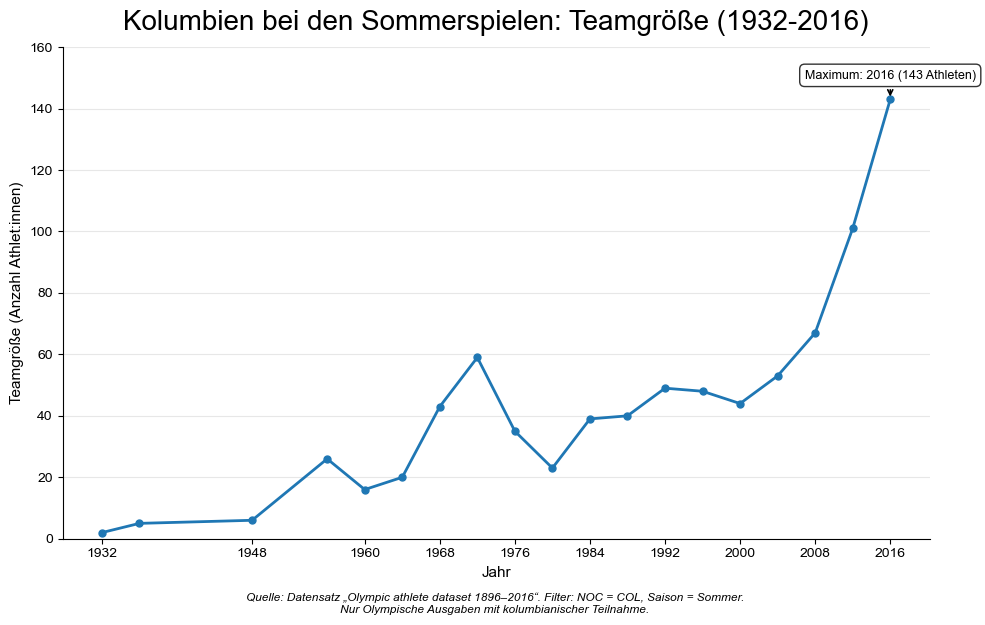

In [291]:
PROJECT_DIR = Path.cwd().parent       
FIG_DIR = PROJECT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# ===== Data =====
years = team_size.index.to_numpy()
values = team_size.values

# ===== Figure =====
fig, ax = plt.subplots(figsize=(10, 6))

# Line with markers
ax.plot(years, values, marker="o", linewidth=2, markersize=5)

# Title and axes
ax.set_title("Kolumbien bei den Sommerspielen: Teamgröße (1932-2016)", 
             fontsize=20, pad=12)
ax.set_xlabel("Jahr", fontsize=11)
ax.set_ylabel("Teamgröße (Anzahl Athlet:innen)", fontsize=11)

# Scale and aesthetics
ax.set_ylim(0, values.max() * 1.12)
ax.grid(True, axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# X ticks
step = 2
ax.set_xticks(years[::step])

# ===== Annotate maximum value =====
y_max = team_size.idxmax()
v_max = team_size.max()
ax.annotate(
    f"Maximum: {y_max} ({v_max} Athleten)",
    xy=(y_max, v_max),
    xytext=(0, 15),
    textcoords="offset points",
    ha="center",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.8),
    arrowprops=dict(arrowstyle="->", linewidth=1.2, color='black')
)

# ===== Footer note =====
note = (
    "Quelle: Datensatz „Olympic athlete dataset 1896–2016“. Filter: NOC = COL, Saison = Sommer.\n"
     "Nur Olympische Ausgaben mit kolumbianischer Teilnahme."
)
fig.text(0.5, -0.03, note, ha='center', fontsize=8.5, style='italic')

plt.tight_layout()

# ===== Save figure =====
fig.savefig(FIG_DIR / "01_team_size.png", dpi=300, bbox_inches="tight")
fig.savefig(FIG_DIR / "01_team_size.pdf", bbox_inches="tight")
plt.show()


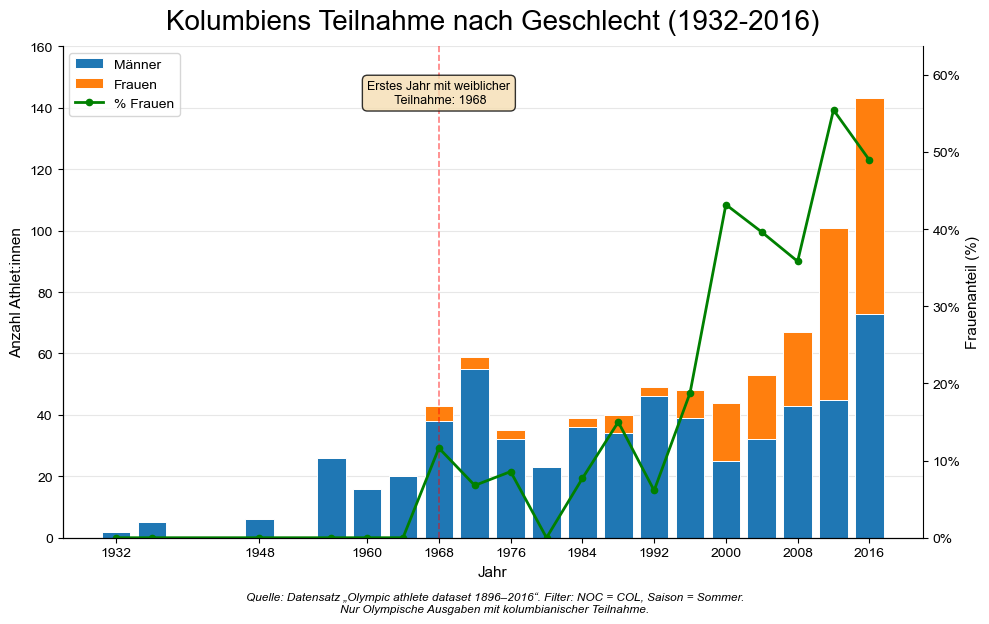

In [292]:
PROJECT_DIR = Path.cwd().parent          
FIG_DIR = PROJECT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# ===== Data =====
counts = gender.reindex(columns=["M", "F"], fill_value=0).copy()
years = counts.index.to_numpy()
female_pct = (gender["Female_Participation"] * 100).fillna(0)
total = counts["M"] + counts["F"]

# ===== Figure =====
fig, ax = plt.subplots(figsize=(10, 6))

bar_w = 3.2

# Stacked bars
ax.bar(
    years, counts["M"], width=bar_w,
    label="Männer", edgecolor="white", linewidth=0.7
)
ax.bar(
    years, counts["F"], width=bar_w, bottom=counts["M"],
    label="Frauen", edgecolor="white", linewidth=0.7
)

# Title and axes
ax.set_title("Kolumbiens Teilnahme nach Geschlecht (1932-2016)", 
             fontsize=20, pad=12)
ax.set_xlabel("Jahr", fontsize=11)
ax.set_ylabel("Anzahl Athlet:innen", fontsize=11)

# Grid and basic aesthetics
ax.set_ylim(0, total.max() * 1.12)
ax.grid(True, axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# X ticks
step = 2
ax.set_xticks(years[::step])

# ===== Secondary axis for % women =====
ax2 = ax.twinx()
ax2.plot(
    years, female_pct,
    linewidth=2, marker="o", markersize=4.5,
    label="% Frauen", color='green'
)
ax2.set_ylabel("Frauenanteil (%)", fontsize=11)
ax2.set_ylim(0, max(60, female_pct.max() * 1.15))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.spines["top"].set_visible(False)

# ===== Legend =====
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="upper left", frameon=True)

# ===== Annotation for first female participation =====
years_with_women = counts.index[counts["F"] > 0]
if len(years_with_women) > 0:
    first_w = int(years_with_women.min())
    
    # Vertical line
    ax.axvline(first_w, linestyle="--", linewidth=1.2, color='red', alpha=0.5)
    
    # Text
    ax.text(
        first_w, ax.get_ylim()[1] * 0.93,
        f"Erstes Jahr mit weiblicher\n Teilnahme: {first_w}",
        ha="center", va="top", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.4", facecolor='wheat', alpha=0.8)
    )

# ===== Footer note =====
note = (
    "Quelle: Datensatz „Olympic athlete dataset 1896–2016“. Filter: NOC = COL, Saison = Sommer.\n"
     "Nur Olympische Ausgaben mit kolumbianischer Teilnahme."
)
fig.text(0.5, -0.03, note, ha='center', fontsize=8.5, style='italic')

plt.tight_layout()

# ===== Save figure =====
fig.savefig(FIG_DIR / "02_gender_composition_area.png", dpi=300, bbox_inches="tight")
fig.savefig(FIG_DIR / "02_gender_composition_area.pdf", bbox_inches="tight")
plt.show()

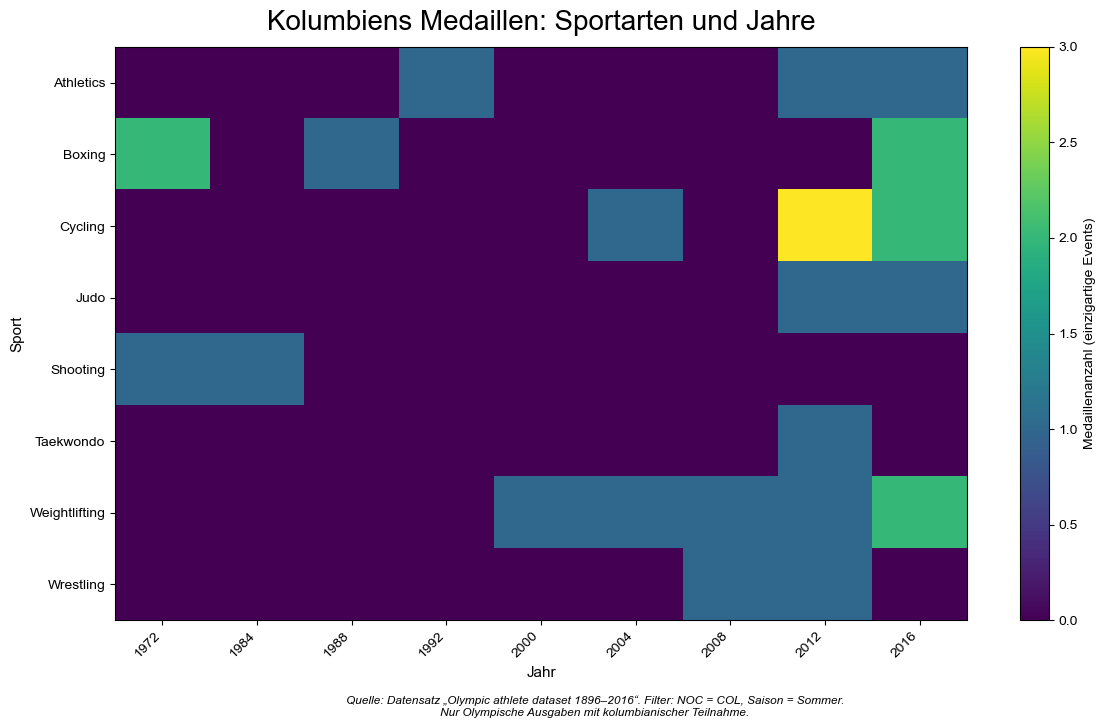

In [293]:
PROJECT_DIR = Path.cwd().parent
FIG_DIR = PROJECT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# ===== Data =====
years = medals_top.columns.astype(int).tolist()
sports = medals_top.index.tolist()

# ===== Figure =====
fig, ax = plt.subplots(figsize=(12, 7))

# Heatmap
im = ax.imshow(medals_top.values, aspect="auto", cmap='viridis', interpolation='nearest')

# Title and labels
ax.set_title("Kolumbiens Medaillen: Sportarten und Jahre", 
             fontsize=20, pad=12)
ax.set_xlabel("Jahr", fontsize=11)
ax.set_ylabel("Sport", fontsize=11)

# Y ticks (sports)
ax.set_yticks(range(len(sports)))
ax.set_yticklabels(sports, fontsize=10)

# X ticks (years)
step = max(1, len(years)//10)
xticks_pos = list(range(0, len(years), step))
xticks_lab = [years[i] for i in xticks_pos]
ax.set_xticks(xticks_pos)
ax.set_xticklabels(xticks_lab, rotation=45, ha="right", fontsize=10)

# Colorbar
cbar = plt.colorbar(im, ax=ax, label="Medal Count")
cbar.set_label("Medaillenanzahl (einzigartige Events)", fontsize=10)


# ===== Footer note =====
note = (
    "Quelle: Datensatz „Olympic athlete dataset 1896–2016“. Filter: NOC = COL, Saison = Sommer.\n"
     "Nur Olympische Ausgaben mit kolumbianischer Teilnahme."
)
fig.text(0.5, -0.03, note, ha='center', fontsize=8.5, style='italic')

plt.tight_layout()

# ===== Save figure =====
fig.savefig(FIG_DIR / "03_medals_heatmap.png", dpi=300, bbox_inches="tight")
fig.savefig(FIG_DIR / "03_medals_heatmap.pdf", bbox_inches="tight")
plt.show()

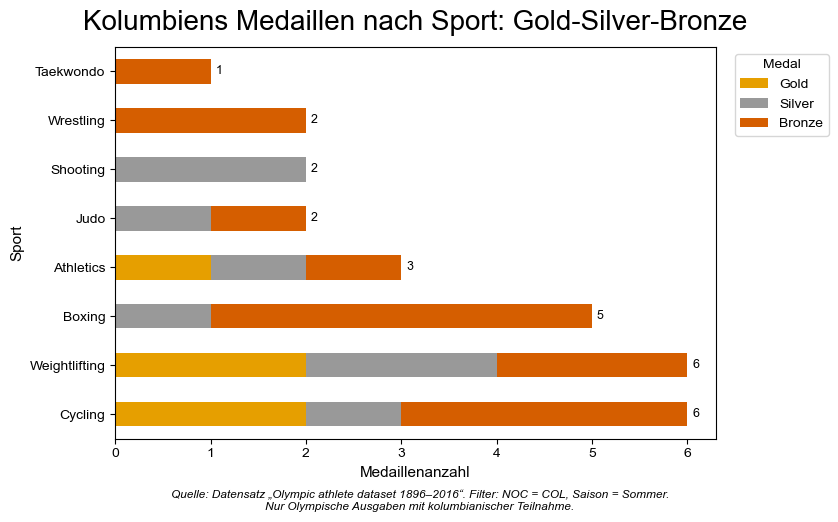

In [294]:
PROJECT_DIR = Path.cwd().parent
FIG_DIR = PROJECT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

medal_type_by_sport = (
    col_medals.pivot_table(index="Sport", columns="Medal", values="ID", aggfunc="count", fill_value=0)
)

medal_type_by_sport["Total"] = medal_type_by_sport.sum(axis=1)
top = medal_type_by_sport.sort_values("Total", ascending=False)

order = [c for c in ['Gold', 'Silver', 'Bronze'] if c in top.columns]
top_plot = top[order]

color_map = {'Gold':'#E69F00', 'Silver':'#999999', 'Bronze':'#D55E00'}
colors = [color_map[c] for c in order]

fig, ax = plt.subplots(figsize=(8.5,5))
top_plot.plot(kind="barh", stacked=True, ax=ax, color=colors)
ax.set_title("Kolumbiens Medaillen nach Sport: Gold-Silver-Bronze", fontsize=20, pad=12)
ax.set_xlabel("Medaillenanzahl")
ax.set_ylabel("Sport")

ax.legend(title='Medal', loc='upper left', bbox_to_anchor=(1.02, 1.0))
totals = top['Total'].values
for i, total in enumerate(totals):
    ax.text(total + 0.05, i, str(int(total)), va='center', fontsize=9)

note = (
    "Quelle: Datensatz „Olympic athlete dataset 1896–2016“. Filter: NOC = COL, Saison = Sommer.\n"
     "Nur Olympische Ausgaben mit kolumbianischer Teilnahme."
)
fig.text(0.5, -0.03, note, ha='center', fontsize=8.5, style='italic')

plt.tight_layout()
fig.savefig(FIG_DIR / "04_medals_typeofmedal.png", dpi=300, bbox_inches="tight")
fig.savefig(FIG_DIR / "04_medals_typeofmedal.pdf", bbox_inches="tight")

plt.show()

### Quiz

Here you have space for your work on the quiz! Good luck and have fun!

### Extract host cities

In [295]:
hosts = athletes.loc[:, ['Games', 'City']]
hosts.drop_duplicates(inplace=True)
host_cities = pd.DataFrame(hosts['City'].unique(), columns=['City'])
host_cities.head()

,City
0,Barcelona
1,London
2,Antwerpen
3,Paris
4,Calgary


## Maps - Primer
This is not mandatory. There will be a lab on maps anyway.


### "Reverse-locate" latitude and longitude

We are using GeoPandas to display maps. See [these instructions](https://geopandas.org/install.html) on how to install GeoPandas.

In [296]:
!pip install geopandas geopy descartes

In [297]:
!pip install geodatasets

In [298]:
import time
import geodatasets
from  geopy.geocoders import Nominatim
from matplotlib.lines import Line2D

In [299]:
host_cities = (
    col_medals.groupby("City")
    .size()
    .reset_index(name="MedalEvents") 
    .sort_values("MedalEvents", ascending=False)
    .reset_index(drop=True)
)

host_cities.head()

,City,MedalEvents
0,London,8
1,Rio de Janeiro,8
2,Munich,3
3,Athina,2
4,Beijing,2


In [300]:
geolocator = Nominatim(user_agent='colombia_olympics_project', timeout=100)
geo_cache = {}
latitudes = []
longitudes = []

for city in host_cities["City"]:
    if city in geo_cache:
        loc = geo_cache[city]
    else:
        loc = geolocator.geocode(city)
        geo_cache[city] = loc
        time.sleep(1) 

    if loc is None:
        latitudes.append(None)
        longitudes.append(None)
        failed.append(city)
    else:
        latitudes.append(loc.latitude)
        longitudes.append(loc.longitude)

Adding the captured latitudinal and longitudinal data to the data frame.

In [301]:
host_cities['latitude'] = latitudes
host_cities['longitude'] = longitudes
host_cities.head()

,City,MedalEvents,latitude,longitude
0,London,8,51.507446,-0.127765
1,Rio de Janeiro,8,-22.911014,-43.209373
2,Munich,3,48.137108,11.575382
3,Athina,2,37.975565,23.734832
4,Beijing,2,40.190632,116.412144


### Define geometry points
Let's do that by means of a GeoDataFrame. Here we use the input from the DataFrame fille previously.

In [302]:
host_cities_geo = host_cities.dropna(subset=["latitude", "longitude"]).copy()

host_cities_geo = gpd.GeoDataFrame(
    host_cities_geo,
    geometry=gpd.points_from_xy(host_cities_geo["longitude"], host_cities_geo["latitude"]),
    crs="EPSG:4326"
)

world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

### Draw and save map
With this piece of code you can create your own map. For more on maps, stay tuned to the lab on maps.

Milestones:
 First medal: 1972 Munich
 First female medal: 1992 Barcelona
 Most medals year(s): [2012, 2016] -> ['London', 'Rio de Janeiro'] (count=8)


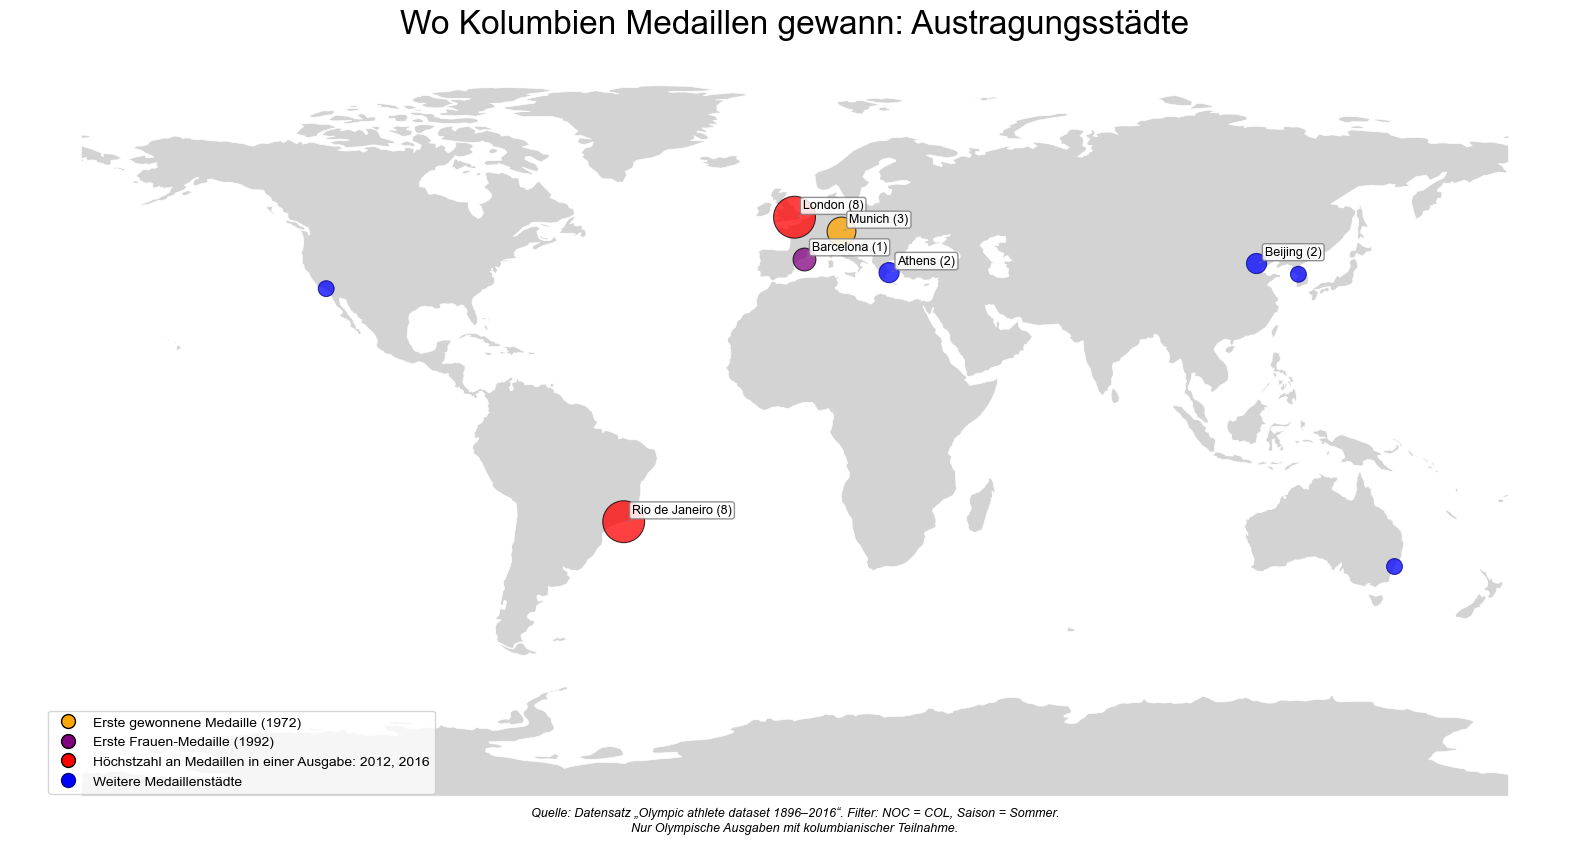

In [303]:
PROJECT_DIR = Path.cwd().parent
FIG_DIR = PROJECT_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)

# Map Year -> City (unique per Olympic edition)
year_city = col_medals[["Year", "City"]].drop_duplicates().set_index("Year")["City"]

# First medal (earliest year with a medal)
first_medal_year = int(col_medals["Year"].min())
first_medal_city = year_city.loc[first_medal_year]

# First female medal (earliest year with a female medal)
female_medals = col_medals[col_medals["Sex"] == "F"].copy()
if female_medals.empty:
    first_female_year = None
    first_female_city = None
else:
    first_female_year = int(female_medals["Year"].min())
    first_female_city = (
        female_medals[["Year", "City"]].drop_duplicates().set_index("Year")["City"].loc[first_female_year]
    )

# Year(s) with most medals
medals_per_year = col_medals.groupby("Year").size().sort_values(ascending=False)
max_count = int(medals_per_year.max())
max_years = medals_per_year[medals_per_year == max_count].index.astype(int).tolist()
max_cities = year_city.loc[max_years].tolist()  # could be more than one if tie

# Add boolean columns to host_cities_geo
host_cities_geo = host_cities_geo.copy()
host_cities_geo["is_first_medal"] = host_cities_geo["City"].eq(first_medal_city)
host_cities_geo["is_max_year"] = host_cities_geo["City"].isin(max_cities)

if first_female_city is None:
    host_cities_geo["is_first_female_medal"] = False
else:
    host_cities_geo["is_first_female_medal"] = host_cities_geo["City"].eq(first_female_city)

host_cities_geo["is_other"] = ~(
    host_cities_geo["is_first_medal"]
    | host_cities_geo["is_max_year"]
    | host_cities_geo["is_first_female_medal"]
)

print("Milestones:")
print(" First medal:", first_medal_year, first_medal_city)
print(" First female medal:", first_female_year, first_female_city)
print(" Most medals year(s):", max_years, "->", max_cities, f"(count={max_count})")

host_cities_geo = host_cities_geo.copy()
city_fix = {
    "Athina": "Athens",
}
host_cities_geo["City_display"] = host_cities_geo["City"].replace(city_fix)

# ===== Figure =====
fig, ax = plt.subplots(figsize=(16, 9))

# World map
world.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.5)
ax.axis("off")

# ===== Colors =====
COL_OTHER = "blue"
COL_FIRST = "orange"
COL_FEM   = "purple"
COL_MAX   = "red"

# DataFrames by category (assumes these boolean columns already exist)
df_other = host_cities_geo[host_cities_geo["is_other"]]
df_first = host_cities_geo[host_cities_geo["is_first_medal"]]
df_fem   = host_cities_geo[host_cities_geo["is_first_female_medal"]]
df_max   = host_cities_geo[host_cities_geo["is_max_year"]]

def plot_layer(df, color, extra_size=0, z=2):
    if len(df) == 0:
        return
    df.plot(
        ax=ax,
        markersize=(50 + df["MedalEvents"] * 80) + extra_size,
        color=color,
        alpha=0.75,
        edgecolor="black" if color != COL_OTHER else "darkblue",
        linewidth=0.8,
        zorder=z
    )

# Plot layers: other first, highlights on top
plot_layer(df_other, COL_OTHER, extra_size=0,   z=2)
plot_layer(df_first, COL_FIRST, extra_size=140, z=4)
plot_layer(df_fem,   COL_FEM,   extra_size=140, z=5)
plot_layer(df_max,   COL_MAX,   extra_size=220, z=6)

# ===== Labels: only "City (medals)" =====
# Label: top 6 by medals + all milestone cities (to keep it readable)
top_general = host_cities_geo.nlargest(5, "MedalEvents")
label_df = pd.concat([top_general, df_first, df_fem, df_max]).drop_duplicates()

for _, row in label_df.iterrows():
    x, y = row.geometry.x, row.geometry.y
    city = row["City_display"]
    medals = int(row["MedalEvents"])

    ax.annotate(
        f"{city} ({medals})",
        xy=(x, y),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.85, edgecolor="gray"),
        arrowprops=dict(arrowstyle="-", linewidth=0.7, color="gray", alpha=0.6),
        zorder=10
    )

# ===== Title =====
ax.set_title("Wo Kolumbien Medaillen gewann: Austragungsstädte",
             fontsize=24, pad=12)

# ===== Legend (ordered as requested) =====
legend_elements = [
    Line2D([0], [0], marker="o", color="w",
           label=f"Erste gewonnene Medaille ({first_medal_year})",
           markerfacecolor=COL_FIRST, markeredgecolor="black", markersize=10),
]

if first_female_year is not None:
    legend_elements.append(
        Line2D([0], [0], marker="o", color="w",
               label=f"Erste Frauen-Medaille ({first_female_year})",
               markerfacecolor=COL_FEM, markeredgecolor="black", markersize=10)
    )

legend_elements.append(
    Line2D([0], [0], marker="o", color="w",
           label=f"Höchstzahl an Medaillen in einer Ausgabe: {', '.join(map(str, max_years))}",
           markerfacecolor=COL_MAX, markeredgecolor="black", markersize=10)
)

legend_elements.append(
    Line2D([0], [0], marker="o", color="w",
           label="Weitere Medaillenstädte",
           markerfacecolor=COL_OTHER, markeredgecolor="darkblue", markersize=10)
)

# Raise legend a bit
ax.legend(
    handles=legend_elements,
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    frameon=True
)

# ===== Footer note =====
note = (
    "Quelle: Datensatz „Olympic athlete dataset 1896–2016“. Filter: NOC = COL, Saison = Sommer.\n"
     "Nur Olympische Ausgaben mit kolumbianischer Teilnahme."
)
fig.text(0.5, 0.09, note, ha="center", fontsize=9, style="italic")

plt.tight_layout(rect=[0, 0.05, 1, 1])

# ===== Save =====
fig.savefig(FIG_DIR / "05_host_cities_withmedals_colored_EN.png", dpi=300, bbox_inches="tight")
fig.savefig(FIG_DIR / "05_host_cities_withmedals_colored_EN.pdf", bbox_inches="tight")
plt.show()
